[TensorRT] WARNING: Using an engine plan file across different models of devices is not recommended and is likely to affect performance or even cause errors.
[TensorRT] WARNING: TensorRT was linked against cuDNN 8.2.1 but loaded cuDNN 8.2.0
[TensorRT] WARNING: TensorRT was linked against cuDNN 8.2.1 but loaded cuDNN 8.2.0


bindings [139721038626816]
host_mem (1566720,) [0. 0. 0. ... 0. 0. 0.]
device_mem <pycuda._driver.DeviceAllocation object at 0x7f14004658a0>
bindings [139721038626816, 139721047015424]
host_mem (24480,) [0. 0. 0. ... 0. 0. 0.]
device_mem <pycuda._driver.DeviceAllocation object at 0x7f1400464850>
bindings [139721038626816, 139721047015424, 139721047113728]
host_mem (6120,) [0. 0. 0. ... 0. 0. 0.]
device_mem <pycuda._driver.DeviceAllocation object at 0x7f1400464530>
(3, 544, 960)
(1566720,)
(1566720,)
img_np1 [0.07058824 0.07058824 0.07058824 ... 0.50980392 0.5372549  0.55294118]
img_np2 Host:
[0.07058824 0.07058824 0.07058824 ... 0.50980395 0.5372549  0.5529412 ]
Device:
TensorRT inference time: 3 ms
boxes [1.0828211 1.6696267 2.8423612 ... 0.6059189 0.436141  0.6151167] 24480
boxes [1.0828211 1.6696267 2.8423612 ... 0.6059189 0.436141  0.6151167] 24480
boxes [1.0828211 1.6696267 2.8423612 ... 0.6059189 0.436141  0.6151167] 24480
class_id : 2, xmin, ymin, w, h : (663, 78, 71, 86)
class_

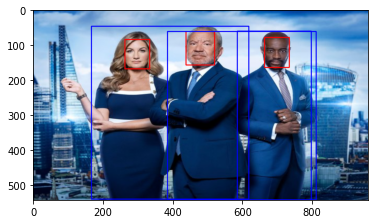

In [1]:
import os
import time

import cv2

import numpy as np
import pycuda.autoinit
import pycuda.driver as cuda
import tensorrt as trt
from PIL import Image
import matplotlib.pyplot as plt

class HostDeviceMem(object):
    def __init__(self, host_mem, device_mem):
        
        self.host = host_mem
        print('host_mem',host_mem.shape, host_mem)
        self.device = device_mem
        print('device_mem', device_mem)

    def __str__(self):
        return "Host:\n" + str(self.host) + "\nDevice:\n" + str(self.device)

    def __repr__(self):
        return self.__str__()


def load_engine(trt_runtime, engine_path):
    with open(engine_path, "rb") as f:
        engine_data = f.read()
    engine = trt_runtime.deserialize_cuda_engine(engine_data)
    return engine


def allocate_buffers(engine, batch_size=1):
    """Allocates host and device buffer for TRT engine inference.
    This function is similair to the one in common.py, but
    converts network outputs (which are np.float32) appropriately
    before writing them to Python buffer. This is needed, since
    TensorRT plugins doesn't support output type description, and
    in our particular case, we use NMS plugin as network output.
    Args:
        engine (trt.ICudaEngine): TensorRT engine
    Returns:
        inputs [HostDeviceMem]: engine input memory
        outputs [HostDeviceMem]: engine output memory
        bindings [int]: buffer to device bindings
        stream (cuda.Stream): cuda stream for engine inference synchronization
    """
    inputs = []
    outputs = []
    bindings = []
    stream = cuda.Stream()

    # Current NMS implementation in TRT only supports DataType.FLOAT but
    # it may change in the future, which could brake this sample here
    # when using lower precision [e.g. NMS output would not be np.float32
    # anymore, even though this is assumed in binding_to_type]
    binding_to_type = {
        "input_1": np.float32,
        "output_bbox/BiasAdd": np.float32,
        "output_cov/Sigmoid": np.float32,
    }

    for binding in engine:
        size = trt.volume(engine.get_binding_shape(binding)) * batch_size
        dtype = binding_to_type[str(binding)]
        # Allocate host and device buffers
        host_mem = cuda.pagelocked_empty(size, dtype)
        device_mem = cuda.mem_alloc(host_mem.nbytes)
        # Append the device buffer to device bindings.
        bindings.append(int(device_mem))
        print('bindings',bindings)
        # Append to the appropriate list.
        if engine.binding_is_input(binding):
            inputs.append(HostDeviceMem(host_mem, device_mem))
        else:
            outputs.append(HostDeviceMem(host_mem, device_mem))
    return inputs, outputs, bindings, stream


# This function is generalized for multiple inputs/outputs.
# inputs and outputs are expected to be lists of HostDeviceMem objects.
def do_inference(context, bindings, inputs, outputs, stream, batch_size=1):
    # Transfer input data to the GPU.
    [cuda.memcpy_htod_async(inp.device, inp.host, stream) for inp in inputs]
    # Run inference.
    context.execute_async(
        batch_size=batch_size, bindings=bindings, stream_handle=stream.handle
    )
    # Transfer predictions back from the GPU.
    [cuda.memcpy_dtoh_async(out.host, out.device, stream) for out in outputs]
    # Synchronize the stream
    stream.synchronize()
    # Return only the host outputs.
    return [out.host for out in outputs]


def process_image(arr, w, h):
    image = Image.fromarray(np.uint8(arr))

    image_resized = image.resize(size=(w, h), resample=Image.BILINEAR)
    img_np = np.array(image_resized)
    # HWC -> CHW
    img_np = img_np.transpose((2, 0, 1))
    # Normalize to [0.0, 1.0] interval (expected by model)
    img_np = (1.0 / 255.0) * img_np
    print(img_np.shape)
    img_np = img_np.ravel()
    print(img_np.shape)
    return img_np


def predict(image, model_w, model_h):
    """Infers model on batch of same sized images resized to fit the model.
    Args:
        image_paths (str): paths to images, that will be packed into batch
            and fed into model
    """
    img = process_image(image, model_w, model_h)
    print(img.shape)
    # Copy it into appropriate place into memory
    # (self.inputs was returned earlier by allocate_buffers())
    
    temp_img = img.ravel()
    np.copyto(inputs[0].host, temp_img)
    
    print('img_np1',temp_img)
    print('img_np2',inputs[0])
    # When infering on single image, we measure inference
    # time to output it to the user
    inference_start_time = time.time()

    # Fetch output from the model
    [detection_out, keepCount_out] = do_inference(
        context, bindings=bindings, inputs=inputs, outputs=outputs, stream=stream
    )

    # Output inference time
    print(
        "TensorRT inference time: {} ms".format(
            int(round((time.time() - inference_start_time) * 1000))
        )
    )

    # And return results
    return detection_out, keepCount_out


# -------------- MODEL PARAMETERS FOR DETECTNET_V2 --------------------------------
model_h = 544
model_w = 960
stride = 16
box_norm = 35.0

grid_h = int(model_h / stride)
grid_w = int(model_w / stride)
grid_size = grid_h * grid_w

grid_centers_w = []
grid_centers_h = []

for i in range(grid_h):
    value = (i * stride + 0.5) / box_norm
    grid_centers_h.append(value)

for i in range(grid_w):
    value = (i * stride + 0.5) / box_norm
    grid_centers_w.append(value)


def applyBoxNorm(o1, o2, o3, o4, x, y):
    """
    Applies the GridNet box normalization
    Args:
        o1 (float): first argument of the result
        o2 (float): second argument of the result
        o3 (float): third argument of the result
        o4 (float): fourth argument of the result
        x: row index on the grid
        y: column index on the grid

    Returns:
        float: rescaled first argument
        float: rescaled second argument
        float: rescaled third argument
        float: rescaled fourth argument
    """
    o1 = (o1 - grid_centers_w[x]) * -box_norm
    o2 = (o2 - grid_centers_h[y]) * -box_norm
    o3 = (o3 + grid_centers_w[x]) * box_norm
    o4 = (o4 + grid_centers_h[y]) * box_norm
    return o1, o2, o3, o4


def postprocess(outputs, min_confidence, analysis_classes, wh_format=True):
    """
    Postprocesses the inference output
    Args:
        outputs (list of float): inference output
        min_confidence (float): min confidence to accept detection
        analysis_classes (list of int): indices of the classes to consider

    Returns: list of list tuple: each element is a two list tuple (x, y) representing the corners of a bb
    """

    bbs = []
    class_ids = []
    scores = []
    for c in analysis_classes:

        x1_idx = c * 4 * grid_size
        y1_idx = x1_idx + grid_size
        x2_idx = y1_idx + grid_size
        y2_idx = x2_idx + grid_size

        boxes = outputs[0]
        print('boxes',boxes, len(boxes))
        for h in range(grid_h):
            for w in range(grid_w):
                i = w + h * grid_w
                score = outputs[1][c * grid_size + i]
                if score >= min_confidence:
                    o1 = boxes[x1_idx + w + h * grid_w]
                    o2 = boxes[y1_idx + w + h * grid_w]
                    o3 = boxes[x2_idx + w + h * grid_w]
                    o4 = boxes[y2_idx + w + h * grid_w]
                    
#                     o1 = boxes[x1_idx + i]
#                     o2 = boxes[y1_idx + i]
#                     o3 = boxes[x2_idx + i]
#                     o4 = boxes[y2_idx + i]

                    o1, o2, o3, o4 = applyBoxNorm(o1, o2, o3, o4, w, h)

                    xmin = int(o1)
                    ymin = int(o2)
                    xmax = int(o3)
                    ymax = int(o4)
                    if wh_format:
                        bbs.append([xmin, ymin, xmax - xmin, ymax - ymin])
                    else:
                        bbs.append([xmin, ymin, xmax, ymax])
                    class_ids.append(c)
                    scores.append(float(score))

    return bbs, class_ids, scores


img_path = '/DATA_17/ij/test/test_image.jpeg'
weights = '/DATA_17/ij/test/resnet34_peoplenet_pruned.etlt_b1_gpu0_fp32.engine'

# TensorRT logger singleton
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
# trt_engine_path = os.path.join("YOUR .TRT FILE HERE")
trt_engine_path = weights

trt_runtime = trt.Runtime(TRT_LOGGER)
trt_engine = load_engine(trt_runtime, trt_engine_path)

# This allocates memory for network inputs/outputs on both CPU and GPU
inputs, outputs, bindings, stream = allocate_buffers(trt_engine)

# Execution context is needed for inference
context = trt_engine.create_execution_context()

image = cv2.imread(img_path)[..., ::-1]

detection_out, keepCount_out = predict(image, model_w, model_h)
# detection_out (24480,) <class 'numpy.ndarray'>
# keepCount_out (6120,) <class 'numpy.ndarray'>


NUM_CLASSES = 3
threshold = 0.3
bboxes, class_ids, scores = postprocess(
    [detection_out, keepCount_out], threshold, list(range(NUM_CLASSES))
)


image_cpy = image.copy()
image_cpy = cv2.resize(image_cpy, (model_w, model_h))

# Final bboxes only take afet NMS
indexes = cv2.dnn.NMSBoxes(bboxes, scores, threshold, 0.5)
for idx in indexes:
    idx = int(idx)
    xmin, ymin, w, h = bboxes[idx]
    class_id = class_ids[idx]
    print(f'class_id : {class_id}, xmin, ymin, w, h : {xmin, ymin, w, h}')
    color = [255, 0, 0] if class_id else [0, 0, 255]
    cv2.rectangle(image_cpy, (xmin, ymin), (xmin + w, ymin + h), color, 2)
plt.imshow(image_cpy)
plt.show()